In [1]:
import ast
import sys
from pathlib import Path

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd

sys.path.append('../lib')
from local_paths import analysis_dir, mplstyle_path
from summary_utils import verified_update, annotate_unit_df, select_units, summarize_results_per_region
from stats_utils import get_bootstrap_spread, fdr_correction
from plot_utils import annotate_per_region_axes, axis_off_save_labels

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
# analysis_name = 'face_specific'  # Fig. 5f1
analysis_name = 'face_specific_match_control'  # Fig. 5e,f2
results_dir = analysis_dir + analysis_name

# analysis-specific conditions
conds = ('Matched nonface, nonface', 'Nonface, face')
cond_palette = dict(zip(conds, ('tab:blue','tab:orange')))
cond_ls = dict(zip(conds, ('--','-')))

# unit selection
unit_sel_path = 'unit_sel/face_selective.csv.gz'
subjs = ('Pa', 'Bo', 'Re')
subj_pal = palettable.cartocolors.qualitative.__dict__[f'Pastel_{len(subjs)}'].mpl_colors

# statistics
spread_type = 'mad'  # for PSTHs; unlike in most other analyses, this spread is across neurons
rej_spread_type = 'ci_of_mean'
if 'match_control' in analysis_name:
    test_dset = 'by_saccade_size/all/psth'
    stat_test = (('Non', 'Face'), 'previous', 'greater')
else:
    test_dset = 'by_saccade/by_saccade_size/all/psth'
    stat_test = (('Non', 'Non'), ('Non', 'Face'), 'less')

# Load data

In [4]:
unit_df = {'Session': [], 'Unit': []}
results = {k: [] for k in ('cond0', 'cond1', 'pvals')}
coords = {}

results_dir = Path(results_dir).expanduser()
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            assert f[f'progress_report/{analysis_name}/all_done'][()]
            dset = f[f'{analysis_name}/{test_dset}']
        except (KeyError, AssertionError):
            continue

        verified_update(coords, dict(time=dset['time'][()]))

        unit_names = dset['unit'][()].astype(str)

        tests = [ast.literal_eval(''.join(v)) for v in dset['test'][()].astype(str)]
        itest = tests.index(stat_test)
        pvals = dset['p-value'][itest]
        vals = dset['data'][itest, :, 0]
        if stat_test[-1] == 'greater':
            vals0, vals1 = vals[[1,0]]
        else:
            vals0, vals1 = vals

        results['pvals'].append(pvals)
        results['cond0'].append(vals0)
        results['cond1'].append(vals1)

    unit_df['Session'].append(np.full(unit_names.size, fp.stem))
    unit_df['Unit'].append(unit_names)

print('coordinates:')
for k, v in coords.items():
    print('\t', k, v.shape, v.dtype)
print('results:')
for d in (results, unit_df):
    for k, v in d.items():
        d[k] = v = np.concatenate(v, axis=-1)
        print('', f'{k:<15s}', v.shape, v.dtype, sep='\t')
print(np.unique(unit_df['Session']).size, 'sessions')
unit_df = annotate_unit_df(pd.DataFrame(unit_df))

coordinates:
	 time (76,) float64
results:
	cond0          	(76, 13102)	float32
	cond1          	(76, 13102)	float32
	pvals          	(76, 13102)	float32
	Session        	(13102,)	<U10
	Unit           	(13102,)	<U3
127 sessions


# Select units

In [5]:
result_vals = np.array([
    results['cond0'],
    results['cond1']])
pvals = results['pvals']
del results

In [6]:
m = result_vals
m = m.reshape(-1, m.shape[-1]).ptp(0) > 0

unit_df, unit_sel, regions = select_units(
    unit_df,
    selection_path=unit_sel_path,
    select_valid_values=m)

result_vals = result_vals[...,unit_sel]
pvals = pvals[...,unit_sel]
if 'match_control' in analysis_name:
    unit_df.reset_index()[['Session','Unit']].to_csv('unit_sel/fig5e.csv.gz', index=False)

> Selected units: n = 2650 of 13102 (20.2% of data, 98.8% of selection) based on face_selective.csv.gz
> Selected units: n = 2536 of 2650 (95.7%) with valid values
> No rare subject to exclude
	 min norm. units per region: Region
	AIT    0.820253
	CIT    1.000000
	Name: Norm. units, dtype: float64


# PSTHs

## Normalize PSTHs

Normalize per unit to spane of `norm_cond`, across conditions x timepoints

In [7]:
norm = result_vals
norm = norm.reshape(-1, norm.shape[-1])
norm = np.array([norm.min(0), norm.max(0)])  # shape (2, nu)
assert np.all(norm.ptp(0) > 0)

norm_results = (result_vals - norm[0]) / norm.ptp(0)

## Summarize PSTHs

In [8]:
# for comments, see code for Fig. 2ce
assert spread_type == 'mad'
unit_df['Subject_'] = unit_df['Subject']
summary = summarize_results_per_region(
    unit_df=unit_df,
    result_vals=norm_results,
    spread_type='ci_of_median',  # calculate center as median; ci unused; spread calculated separately below
    level1='Subject',
    level2='Subject_',
    n_bootstraps=0)

## Make plots

In [9]:
def mad(a, axis=-1):
    m = np.nanmedian(a, axis=axis, keepdims=True)
    return np.nanmedian(np.abs(a-m), axis=axis)

center/spread estimate: mad


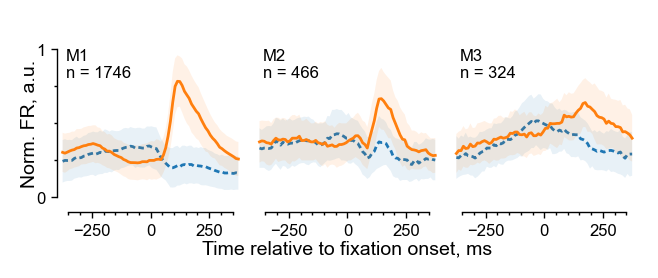

In [10]:
fig, axs = plt.subplots(1, len(subjs), figsize=(1.25*len(subjs),1.25), sharex=True)
plt.subplots_adjust(wspace=0.05)

ts = coords['time']
for subj, ax in zip(subjs, axs):
    m, bs = summary['one-level_center_boots'][subj]
    for icond, cond in enumerate(conds):
        color = cond_palette[cond]
        ls = cond_ls[cond]
        ax.plot(ts, m[icond], color=color, ls=ls, zorder=2+icond/4)
        s = mad(summary['two-level_vals'][subj][subj][icond])
        spread = (m[icond]-s, m[icond]+s)
        ax.fill_between(ts, *spread, ec='none', fc=color, alpha=0.1, zorder=1.9+icond/4)

xlim = (-400, 400)
xtks = (-250, 0, 250)
xmtks = np.arange(-350, 351, 50)
for ax in axs:
    ax.set_xlim(xlim)
    ax.set_xticks(xtks)
    ax.set_xticks(xmtks, minor=True)
    ax.spines['bottom'].set_bounds(xmtks.min(), xmtks.max())

ybound = (0, 1)
ylim = (-.1, 1.2)
ymtks = (.25,.5,.75)
for i, ax in enumerate(axs):
    ax.set_ylim(ylim)
    if i:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
    else:
        ax.set_yticks(ybound)
        ax.set_yticklabels(list(map(str, ybound)))
        ax.set_yticks(ymtks, minor=True)
        ax.spines['left'].set_bounds(ybound)

ax = axs[0]
ax.set_ylabel('Norm. FR, a.u.')
tform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-.1, np.mean(ybound), transform=tform)

ax = fig.add_subplot(111)
axis_off_save_labels(ax)
ax.set_xlabel('Time relative to fixation onset, ms', labelpad=10)

annotate_per_region_axes(
    axs,
    subjs,
    ns_per_region=summary['two-level_nunit'],
    conds=[],
    palette=cond_palette,
    region_labels=tuple(f'M{i+1}' for i in range(3)),
    show_num_subj=False,
    h=.85)

print('center/spread estimate:', spread_type)

if 'match_control' in analysis_name:
    plt.savefig('plots/fig5e.png')

# Per-unit stat tests

## Correct for multiple comparisons

In [11]:
# apply multi-comparisons correction
reject = np.zeros(pvals.shape, dtype=bool)
apvals = np.full_like(pvals, np.nan)

# correction is done per time bin; otherwise,
# correcetion mixes early and late time bins,
# affecting each other's test sensitivity
for it in range(len(pvals)):
    m = np.isfinite(pvals[it])
    reject[it,m], apvals[it,m] = (v[None] for v in fdr_correction({None: pvals[it,m]}))

## Summarize per-unit stats

In [12]:
rej_summary = summarize_results_per_region(
    unit_df=unit_df,
    result_vals=reject[None,...],
    spread_type=rej_spread_type,
    level1='Subject',
    level2='Subject_')

center/spread estimate: ci_of_mean


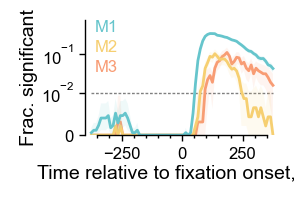

In [13]:
fig = plt.figure(figsize=(1.25, .75))
ax = plt.gca()

icond = 0
for isubj, (subj, color) in enumerate(zip(subjs, subj_pal)):
    m, bs = rej_summary['one-level_center_boots'][subj]
    ax.plot(ts, m[icond], color=color, zorder=2-isubj/10)
    spread = get_bootstrap_spread(m[icond], bs[:,icond], rej_spread_type)
    ax.fill_between(ts, *spread, ec='none', fc=color, alpha=0.1, zorder=1.95-isubj/10)

ax.hlines(.01, ts[0], ts[-1], colors='gray', ls='--', lw=0.5, zorder=-1)
ax.set_yscale('symlog', linthresh=.01)

xlim = (-400, 400)
xtks = (-250, 0, 250)
xmtks = np.arange(-350, 351, 50)
ax.set_xlim(xlim)
ax.set_xticks(xtks)
ax.set_xticks(xmtks, minor=True)
ax.spines['bottom'].set_bounds(xmtks.min(), xmtks.max())
ax.set_xlabel('Time relative to fixation onset, ms')

ybound = (0, .8)
ax.set_ylim(ybound)
ax.spines['left'].set_bounds(ybound)
ax.set_ylabel('Frac. significant')

h = 1
for isubj, (subj, color) in enumerate(zip(subjs, subj_pal)):
    ax.text(
        .05, h, f'M{isubj+1}',
        ha='left', va='top', transform=ax.transAxes,
        color=color, fontsize=6)
    h -= .175

print('center/spread estimate:', rej_spread_type)

if 'match_control' in analysis_name:
    plt.savefig('plots/fig5f2.png')
else:
    plt.savefig('plots/fig5f1.png')